# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='Retweet'
PRFX='Retweet0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL retwt
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 5.54 s, sys: 460 ms, total: 6 s
Wall time: 6.68 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(500000, 24)


retwt          0.113632
reply          0.027396
like           0.438598
retwt_cmmnt    0.007824
dtype: float64

CPU times: user 6.56 s, sys: 406 ms, total: 6.97 s
Wall time: 7.24 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.113632
500000 56816 500000 56816


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
0,101\t56898\t137\t14248\t10567\t77966\t11166\t1...,NaN,A964AF200DAFFEBCB632CE2196DFBE6F,NaN,NaN,NaN,Retweet,022EC308651FACB02794A8147AEE1B78,1581227402,E43C242721C2336F88D163ADFDB2A364,27901,306,False,1351736247,06E9B34C49824F5C612B01F3DF66C4B8,48,977,False,1493475569,False,True,False,False,False
1,101\t29922\t10230\t112\t11368\t112\t12469\t169...,NaN,CA95806CCD16ADD6164D8B632345A5B6,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581415813,520F4141FB74447AA2D5100C12656DF2,190829,2227,True,1246308293,06E9B485CA5F2757CB554B0244FE2FA4,2024,1227,False,1234745553,False,False,False,True,False
2,101\t16358\t10107\t117\t146\t100\t181\t32342\t...,NaN,EAB281F4E0B985324DB134D922D7753C,NaN,NaN,NaN,Quote,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581524517,EC1254C86CED1D8F2B556786329FD939,225223,1365,True,1238211373,06E9B485CA5F2757CB554B0244FE2FA4,2024,1227,False,1234745553,False,True,False,True,False
3,101\t49004\t24951\t11517\t21793\t49004\t46900\...,E35EBE28C67E02E3EAABD4D383303A10\tBF43374FADDC...,55F436653590B79DC49DCA2FC5E6BA6E,Photo,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581098413,09567D1DEB473ABA2CD04D06F1F6D22D,3110429,39,True,1243169868,06E9B6ABEB6C57CA5A394DADF375D940,557,466,False,1509320658,False,False,False,True,False
4,101\t320\t108660\t18492\t105861\t26349\t10174\...,NaN,2F374BA8A03CFA7B51594FBBD45E4BA6,Photo,E07397470C5AD4AC2420A832A49E045B,476213C6321CD12B64C1FB76A6CE02CA,TopLevel,4DC22C3F31C5C43721E6B5815A595ED6,1581158393,DF856F242E9519638FD447D0CCFA06DF,4245504,54,True,1248789982,06E9B7217C92B280231E835F1B686176,8,74,False,1346060212,False,False,False,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 20:46:33 start
2020-04-11 20:46:48 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:47:06 freq of tags
2020-04-11 20:47:14 done
CPU times: user 34.4 s, sys: 3.66 s, total: 38 s
Wall time: 41.4 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 20:47:15 start
2020-04-11 20:47:27 freq of columns using CountEncoder
2020-04-11 20:47:45 freq of tags
2020-04-11 20:47:52 done
CPU times: user 33.7 s, sys: 3.16 s, total: 36.8 s
Wall time: 37.8 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 31.5 s, sys: 6.74 s, total: 38.3 s
Wall time: 41.8 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
#  'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
#  'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
#  'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
#  'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
29


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.302698	vl's binary_logloss: 0.313062
[200]	tr's binary_logloss: 0.296065	vl's binary_logloss: 0.312213
[300]	tr's binary_logloss: 0.29034	vl's binary_logloss: 0.311852
[400]	tr's binary_logloss: 0.285238	vl's binary_logloss: 0.311785
Early stopping, best iteration is:
[346]	tr's binary_logloss: 0.28783	vl's binary_logloss: 0.31173


tune_feature_fraction, val_score: 0.311730:  14%|#4        | 1/7 [00:27<02:45, 27.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.302146	vl's binary_logloss: 0.313483
[200]	tr's binary_logloss: 0.294497	vl's binary_logloss: 0.312553
[300]	tr's binary_logloss: 0.28863	vl's binary_logloss: 0.312318
[400]	tr's binary_logloss: 0.283357	vl's binary_logloss: 0.312367
Early stopping, best iteration is:
[320]	tr's binary_logloss: 0.287454	vl's binary_logloss: 0.312226


tune_feature_fraction, val_score: 0.311730:  29%|##8       | 2/7 [00:50<02:11, 26.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.301551	vl's binary_logloss: 0.313346
[200]	tr's binary_logloss: 0.293968	vl's binary_logloss: 0.312758
[300]	tr's binary_logloss: 0.28818	vl's binary_logloss: 0.312782
Early stopping, best iteration is:
[243]	tr's binary_logloss: 0.291341	vl's binary_logloss: 0.312704


tune_feature_fraction, val_score: 0.311730:  43%|####2     | 3/7 [01:15<01:42, 25.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.300866	vl's binary_logloss: 0.313705
[200]	tr's binary_logloss: 0.292429	vl's binary_logloss: 0.312946
[300]	tr's binary_logloss: 0.286219	vl's binary_logloss: 0.312874
Early stopping, best iteration is:
[269]	tr's binary_logloss: 0.288159	vl's binary_logloss: 0.312714


tune_feature_fraction, val_score: 0.311730:  57%|#####7    | 4/7 [01:45<01:20, 26.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.299197	vl's binary_logloss: 0.314139
[200]	tr's binary_logloss: 0.290829	vl's binary_logloss: 0.313612
[300]	tr's binary_logloss: 0.284089	vl's binary_logloss: 0.313687
Early stopping, best iteration is:
[224]	tr's binary_logloss: 0.289157	vl's binary_logloss: 0.313513


tune_feature_fraction, val_score: 0.311730:  71%|#######1  | 5/7 [02:13<00:54, 27.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.298776	vl's binary_logloss: 0.31438
[200]	tr's binary_logloss: 0.290281	vl's binary_logloss: 0.314075
[300]	tr's binary_logloss: 0.283324	vl's binary_logloss: 0.314117
Early stopping, best iteration is:
[207]	tr's binary_logloss: 0.289737	vl's binary_logloss: 0.314013


tune_feature_fraction, val_score: 0.311730:  86%|########5 | 6/7 [02:40<00:27, 27.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.298457	vl's binary_logloss: 0.314664
[200]	tr's binary_logloss: 0.28931	vl's binary_logloss: 0.314771
Early stopping, best iteration is:
[103]	tr's binary_logloss: 0.297988	vl's binary_logloss: 0.314585


tune_num_leaves, val_score: 0.311730:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267414	vl's binary_logloss: 0.311181
[200]	tr's binary_logloss: 0.243235	vl's binary_logloss: 0.311512
Early stopping, best iteration is:
[120]	tr's binary_logloss: 0.261594	vl's binary_logloss: 0.311139


tune_num_leaves, val_score: 0.311139:   5%|5         | 1/20 [00:48<15:27, 48.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.299906	vl's binary_logloss: 0.312811
[200]	tr's binary_logloss: 0.2919	vl's binary_logloss: 0.312034
[300]	tr's binary_logloss: 0.285344	vl's binary_logloss: 0.311769
[400]	tr's binary_logloss: 0.279506	vl's binary_logloss: 0.311532
[500]	tr's binary_logloss: 0.273982	vl's binary_logloss: 0.311443
[600]	tr's binary_logloss: 0.268981	vl's binary_logloss: 0.311339
Early stopping, best iteration is:
[566]	tr's binary_logloss: 0.270645	vl's binary_logloss: 0.311275


tune_num_leaves, val_score: 0.311139:  10%|#         | 2/20 [01:37<14:35, 48.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.31255	vl's binary_logloss: 0.31675
[200]	tr's binary_logloss: 0.308458	vl's binary_logloss: 0.314952
[300]	tr's binary_logloss: 0.305668	vl's binary_logloss: 0.314121
[400]	tr's binary_logloss: 0.303091	vl's binary_logloss: 0.313541
[500]	tr's binary_logloss: 0.300814	vl's binary_logloss: 0.313092
[600]	tr's binary_logloss: 0.298668	vl's binary_logloss: 0.312563
[700]	tr's binary_logloss: 0.296605	vl's binary_logloss: 0.312339
[800]	tr's binary_logloss: 0.294699	vl's binary_logloss: 0.312174
[900]	tr's binary_logloss: 0.293009	vl's binary_logloss: 0.312101
[1000]	tr's binary_logloss: 0.291428	vl's binary_logloss: 0.312009
[1100]	tr's binary_logloss: 0.289869	vl's binary_logloss: 0.312016
Early stopping, best iteration is:
[1049]	tr's binary_logloss: 0.290687	vl's binary_logloss: 0.311927


tune_num_leaves, val_score: 0.311139:  15%|#5        | 3/20 [02:32<14:20, 50.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.297501	vl's binary_logloss: 0.312355
[200]	tr's binary_logloss: 0.288304	vl's binary_logloss: 0.31158
[300]	tr's binary_logloss: 0.280574	vl's binary_logloss: 0.311553
Early stopping, best iteration is:
[269]	tr's binary_logloss: 0.282602	vl's binary_logloss: 0.311349


tune_num_leaves, val_score: 0.311139:  20%|##        | 4/20 [03:07<12:13, 45.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.302144	vl's binary_logloss: 0.313109
[200]	tr's binary_logloss: 0.295118	vl's binary_logloss: 0.312311
[300]	tr's binary_logloss: 0.289322	vl's binary_logloss: 0.312019
[400]	tr's binary_logloss: 0.284094	vl's binary_logloss: 0.311959
[500]	tr's binary_logloss: 0.279003	vl's binary_logloss: 0.311914
[600]	tr's binary_logloss: 0.274372	vl's binary_logloss: 0.311929
Early stopping, best iteration is:
[547]	tr's binary_logloss: 0.277012	vl's binary_logloss: 0.311846


tune_num_leaves, val_score: 0.311139:  25%|##5       | 5/20 [03:50<11:18, 45.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27513	vl's binary_logloss: 0.31111
[200]	tr's binary_logloss: 0.253749	vl's binary_logloss: 0.311496
Early stopping, best iteration is:
[120]	tr's binary_logloss: 0.270172	vl's binary_logloss: 0.311016


tune_num_leaves, val_score: 0.311016:  30%|###       | 6/20 [04:26<09:52, 42.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.316663	vl's binary_logloss: 0.319352
[200]	tr's binary_logloss: 0.313001	vl's binary_logloss: 0.316928
[300]	tr's binary_logloss: 0.310635	vl's binary_logloss: 0.315843
[400]	tr's binary_logloss: 0.308481	vl's binary_logloss: 0.31494
[500]	tr's binary_logloss: 0.306761	vl's binary_logloss: 0.314438
[600]	tr's binary_logloss: 0.30535	vl's binary_logloss: 0.314022
[700]	tr's binary_logloss: 0.304001	vl's binary_logloss: 0.313676
[800]	tr's binary_logloss: 0.302694	vl's binary_logloss: 0.313234
[900]	tr's binary_logloss: 0.301475	vl's binary_logloss: 0.312999
[1000]	tr's binary_logloss: 0.300367	vl's binary_logloss: 0.312876
[1100]	tr's binary_logloss: 0.29923	vl's binary_logloss: 0.312777
[1200]	tr's binary_logloss: 0.29829	vl's binary_logloss: 0.312709
[1300]	tr's binary_logloss: 0.297264	vl's binary_logloss: 0.312703
Early stopping, best iteration is:
[1244]	tr's binary_logloss: 0.297812	vl's bin

tune_num_leaves, val_score: 0.311016:  35%|###5      | 7/20 [05:19<09:51, 45.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.295804	vl's binary_logloss: 0.312092
[200]	tr's binary_logloss: 0.285771	vl's binary_logloss: 0.311294
[300]	tr's binary_logloss: 0.277387	vl's binary_logloss: 0.311133
[400]	tr's binary_logloss: 0.270011	vl's binary_logloss: 0.311407
Early stopping, best iteration is:
[313]	tr's binary_logloss: 0.27639	vl's binary_logloss: 0.311079


tune_num_leaves, val_score: 0.311016:  40%|####      | 8/20 [05:47<08:01, 40.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.310287	vl's binary_logloss: 0.315492
[200]	tr's binary_logloss: 0.306054	vl's binary_logloss: 0.314028
[300]	tr's binary_logloss: 0.302888	vl's binary_logloss: 0.313428
[400]	tr's binary_logloss: 0.299867	vl's binary_logloss: 0.31282
[500]	tr's binary_logloss: 0.296914	vl's binary_logloss: 0.312582
[600]	tr's binary_logloss: 0.294354	vl's binary_logloss: 0.312266
[700]	tr's binary_logloss: 0.291919	vl's binary_logloss: 0.312248
[800]	tr's binary_logloss: 0.289653	vl's binary_logloss: 0.312072
[900]	tr's binary_logloss: 0.287538	vl's binary_logloss: 0.312019
Early stopping, best iteration is:
[817]	tr's binary_logloss: 0.289284	vl's binary_logloss: 0.311991


tune_num_leaves, val_score: 0.311016:  45%|####5     | 9/20 [06:28<07:24, 40.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274492	vl's binary_logloss: 0.311034
Early stopping, best iteration is:
[96]	tr's binary_logloss: 0.275611	vl's binary_logloss: 0.310995


tune_num_leaves, val_score: 0.310995:  50%|#####     | 10/20 [07:00<06:18, 37.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28409	vl's binary_logloss: 0.311396
[200]	tr's binary_logloss: 0.267428	vl's binary_logloss: 0.311622
Early stopping, best iteration is:
[118]	tr's binary_logloss: 0.280754	vl's binary_logloss: 0.31131


tune_num_leaves, val_score: 0.310995:  55%|#####5    | 11/20 [07:26<05:09, 34.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269351	vl's binary_logloss: 0.311902
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.281203	vl's binary_logloss: 0.311712


tune_num_leaves, val_score: 0.310995:  60%|######    | 12/20 [07:58<04:30, 33.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.276478	vl's binary_logloss: 0.311315
[200]	tr's binary_logloss: 0.256402	vl's binary_logloss: 0.31131
Early stopping, best iteration is:
[123]	tr's binary_logloss: 0.271412	vl's binary_logloss: 0.311193


tune_num_leaves, val_score: 0.310995:  65%|######5   | 13/20 [08:33<03:57, 33.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261296	vl's binary_logloss: 0.311421
Early stopping, best iteration is:
[94]	tr's binary_logloss: 0.263452	vl's binary_logloss: 0.311318


tune_num_leaves, val_score: 0.310995:  70%|#######   | 14/20 [09:09<03:28, 34.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.279834	vl's binary_logloss: 0.311153
[200]	tr's binary_logloss: 0.261922	vl's binary_logloss: 0.311089
Early stopping, best iteration is:
[161]	tr's binary_logloss: 0.268567	vl's binary_logloss: 0.310957


tune_num_leaves, val_score: 0.310957:  75%|#######5  | 15/20 [09:40<02:47, 33.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.287571	vl's binary_logloss: 0.311844
[200]	tr's binary_logloss: 0.273584	vl's binary_logloss: 0.31163
[300]	tr's binary_logloss: 0.261559	vl's binary_logloss: 0.311671
Early stopping, best iteration is:
[249]	tr's binary_logloss: 0.267432	vl's binary_logloss: 0.311478


tune_num_leaves, val_score: 0.310957:  80%|########  | 16/20 [10:12<02:12, 33.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277901	vl's binary_logloss: 0.311353
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.279463	vl's binary_logloss: 0.311271


tune_num_leaves, val_score: 0.310957:  85%|########5 | 17/20 [10:36<01:31, 30.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270215	vl's binary_logloss: 0.311245
[200]	tr's binary_logloss: 0.24701	vl's binary_logloss: 0.311251
Early stopping, best iteration is:
[126]	tr's binary_logloss: 0.262948	vl's binary_logloss: 0.311168


tune_num_leaves, val_score: 0.310957:  90%|######### | 18/20 [11:05<00:59, 29.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.287556	vl's binary_logloss: 0.311707
[200]	tr's binary_logloss: 0.273029	vl's binary_logloss: 0.311584
[300]	tr's binary_logloss: 0.261158	vl's binary_logloss: 0.311908
Early stopping, best iteration is:
[204]	tr's binary_logloss: 0.272514	vl's binary_logloss: 0.311547


tune_num_leaves, val_score: 0.310957:  95%|#########5| 19/20 [11:35<00:30, 30.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264166	vl's binary_logloss: 0.31143
Early stopping, best iteration is:
[90]	tr's binary_logloss: 0.267421	vl's binary_logloss: 0.31128


tune_num_leaves, val_score: 0.310957: 100%|##########| 20/20 [12:14<00:00, 36.72s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.282347	vl's binary_logloss: 0.311985
[200]	tr's binary_logloss: 0.263216	vl's binary_logloss: 0.312009
Early stopping, best iteration is:
[174]	tr's binary_logloss: 0.267663	vl's binary_logloss: 0.311797


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  10%|#         | 1/10 [00:28<04:14, 28.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28522	vl's binary_logloss: 0.313571
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.288655	vl's binary_logloss: 0.313533


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  20%|##        | 2/10 [00:44<03:16, 24.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280289	vl's binary_logloss: 0.311467
[200]	tr's binary_logloss: 0.262867	vl's binary_logloss: 0.311343
Early stopping, best iteration is:
[180]	tr's binary_logloss: 0.265939	vl's binary_logloss: 0.311251


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  30%|###       | 3/10 [01:07<02:49, 24.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28366	vl's binary_logloss: 0.311967
[200]	tr's binary_logloss: 0.264338	vl's binary_logloss: 0.312124
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.279842	vl's binary_logloss: 0.311861


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  40%|####      | 4/10 [01:24<02:12, 22.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.283818	vl's binary_logloss: 0.312829
[200]	tr's binary_logloss: 0.264522	vl's binary_logloss: 0.313127
Early stopping, best iteration is:
[118]	tr's binary_logloss: 0.279654	vl's binary_logloss: 0.312677


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  50%|#####     | 5/10 [01:40<01:40, 20.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28092	vl's binary_logloss: 0.311509
[200]	tr's binary_logloss: 0.262262	vl's binary_logloss: 0.311796
Early stopping, best iteration is:
[120]	tr's binary_logloss: 0.276577	vl's binary_logloss: 0.311336


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  60%|######    | 6/10 [01:59<01:19, 19.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28388	vl's binary_logloss: 0.312467
[200]	tr's binary_logloss: 0.264559	vl's binary_logloss: 0.31279
Early stopping, best iteration is:
[113]	tr's binary_logloss: 0.280988	vl's binary_logloss: 0.312373


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  70%|#######   | 7/10 [02:16<00:56, 18.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284283	vl's binary_logloss: 0.312626
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.285798	vl's binary_logloss: 0.312355


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  80%|########  | 8/10 [02:33<00:36, 18.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.282984	vl's binary_logloss: 0.311933
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.284549	vl's binary_logloss: 0.311851


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957:  90%|######### | 9/10 [02:47<00:17, 17.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281597	vl's binary_logloss: 0.311658
[200]	tr's binary_logloss: 0.262378	vl's binary_logloss: 0.311589
Early stopping, best iteration is:
[123]	tr's binary_logloss: 0.276413	vl's binary_logloss: 0.311437


tune_bagging_fraction_and_bagging_freq, val_score: 0.310957: 100%|##########| 10/10 [03:04<00:00, 18.42s/it]
tune_feature_fraction, val_score: 0.310957:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.279834	vl's binary_logloss: 0.311153
[200]	tr's binary_logloss: 0.261922	vl's binary_logloss: 0.311089
Early stopping, best iteration is:
[161]	tr's binary_logloss: 0.268567	vl's binary_logloss: 0.310957


tune_feature_fraction, val_score: 0.310957:  33%|###3      | 1/3 [00:17<00:34, 17.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.279066	vl's binary_logloss: 0.311489
Early stopping, best iteration is:
[89]	tr's binary_logloss: 0.281664	vl's binary_logloss: 0.31143


tune_feature_fraction, val_score: 0.310957:  67%|######6   | 2/3 [00:32<00:16, 16.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278584	vl's binary_logloss: 0.311889
[200]	tr's binary_logloss: 0.259638	vl's binary_logloss: 0.312139
Early stopping, best iteration is:
[121]	tr's binary_logloss: 0.273937	vl's binary_logloss: 0.31188


tune_feature_fraction, val_score: 0.310957: 100%|##########| 3/3 [00:49<00:00, 16.58s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.310957:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.279834	vl's binary_logloss: 0.311153
[200]	tr's binary_logloss: 0.261922	vl's binary_logloss: 0.311089
Early stopping, best iteration is:
[161]	tr's binary_logloss: 0.268567	vl's binary_logloss: 0.310957


tune_lambda_l1_and_lambda_l2, val_score: 0.310957:   5%|5         | 1/20 [00:19<06:04, 19.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.279834	vl's binary_logloss: 0.311153
[200]	tr's binary_logloss: 0.261973	vl's binary_logloss: 0.311119
Early stopping, best iteration is:
[161]	tr's binary_logloss: 0.268567	vl's binary_logloss: 0.310957


tune_lambda_l1_and_lambda_l2, val_score: 0.310957:  10%|#         | 2/20 [00:39<05:51, 19.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280059	vl's binary_logloss: 0.311171
[200]	tr's binary_logloss: 0.262039	vl's binary_logloss: 0.311368
Early stopping, best iteration is:
[118]	tr's binary_logloss: 0.276302	vl's binary_logloss: 0.311006


tune_lambda_l1_and_lambda_l2, val_score: 0.310957:  15%|#5        | 3/20 [00:57<05:22, 18.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280882	vl's binary_logloss: 0.311352
[200]	tr's binary_logloss: 0.263281	vl's binary_logloss: 0.311215
[300]	tr's binary_logloss: 0.248107	vl's binary_logloss: 0.311686
Early stopping, best iteration is:
[203]	tr's binary_logloss: 0.262749	vl's binary_logloss: 0.311125


tune_lambda_l1_and_lambda_l2, val_score: 0.310957:  20%|##        | 4/20 [01:20<05:22, 20.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281763	vl's binary_logloss: 0.31118
[200]	tr's binary_logloss: 0.264561	vl's binary_logloss: 0.311124
Early stopping, best iteration is:
[164]	tr's binary_logloss: 0.270145	vl's binary_logloss: 0.310892


tune_lambda_l1_and_lambda_l2, val_score: 0.310892:  25%|##5       | 5/20 [01:46<05:28, 21.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.279834	vl's binary_logloss: 0.311153
[200]	tr's binary_logloss: 0.261973	vl's binary_logloss: 0.311119
Early stopping, best iteration is:
[161]	tr's binary_logloss: 0.268567	vl's binary_logloss: 0.310957


tune_lambda_l1_and_lambda_l2, val_score: 0.310892:  30%|###       | 6/20 [02:12<05:23, 23.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.282259	vl's binary_logloss: 0.311126
[200]	tr's binary_logloss: 0.265431	vl's binary_logloss: 0.310995
Early stopping, best iteration is:
[126]	tr's binary_logloss: 0.277326	vl's binary_logloss: 0.310846


tune_lambda_l1_and_lambda_l2, val_score: 0.310846:  35%|###5      | 7/20 [02:37<05:08, 23.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280097	vl's binary_logloss: 0.311299
[200]	tr's binary_logloss: 0.261666	vl's binary_logloss: 0.311259
Early stopping, best iteration is:
[127]	tr's binary_logloss: 0.274387	vl's binary_logloss: 0.311011


tune_lambda_l1_and_lambda_l2, val_score: 0.310846:  40%|####      | 8/20 [02:57<04:31, 22.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280178	vl's binary_logloss: 0.311447
[200]	tr's binary_logloss: 0.261908	vl's binary_logloss: 0.311326
Early stopping, best iteration is:
[127]	tr's binary_logloss: 0.274566	vl's binary_logloss: 0.311233


tune_lambda_l1_and_lambda_l2, val_score: 0.310846:  45%|####5     | 9/20 [03:15<03:52, 21.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280286	vl's binary_logloss: 0.311253
[200]	tr's binary_logloss: 0.261556	vl's binary_logloss: 0.311028
Early stopping, best iteration is:
[198]	tr's binary_logloss: 0.261992	vl's binary_logloss: 0.311008


tune_lambda_l1_and_lambda_l2, val_score: 0.310846:  50%|#####     | 10/20 [03:36<03:32, 21.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.283381	vl's binary_logloss: 0.311169
[200]	tr's binary_logloss: 0.267385	vl's binary_logloss: 0.310888
[300]	tr's binary_logloss: 0.255497	vl's binary_logloss: 0.311165
Early stopping, best iteration is:
[217]	tr's binary_logloss: 0.265036	vl's binary_logloss: 0.310778


tune_lambda_l1_and_lambda_l2, val_score: 0.310778:  55%|#####5    | 11/20 [04:13<03:52, 25.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284126	vl's binary_logloss: 0.311037
[200]	tr's binary_logloss: 0.269025	vl's binary_logloss: 0.310764
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.270092	vl's binary_logloss: 0.310694


tune_lambda_l1_and_lambda_l2, val_score: 0.310694:  60%|######    | 12/20 [04:51<03:56, 29.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280326	vl's binary_logloss: 0.311651
[200]	tr's binary_logloss: 0.262056	vl's binary_logloss: 0.311683
Early stopping, best iteration is:
[128]	tr's binary_logloss: 0.274567	vl's binary_logloss: 0.311443


tune_lambda_l1_and_lambda_l2, val_score: 0.310694:  65%|######5   | 13/20 [05:13<03:11, 27.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.283789	vl's binary_logloss: 0.311139
[200]	tr's binary_logloss: 0.269024	vl's binary_logloss: 0.310884
[300]	tr's binary_logloss: 0.256472	vl's binary_logloss: 0.311155
Early stopping, best iteration is:
[210]	tr's binary_logloss: 0.267802	vl's binary_logloss: 0.310865


tune_lambda_l1_and_lambda_l2, val_score: 0.310694:  70%|#######   | 14/20 [05:41<02:44, 27.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.279809	vl's binary_logloss: 0.311178
[200]	tr's binary_logloss: 0.261053	vl's binary_logloss: 0.31108
Early stopping, best iteration is:
[192]	tr's binary_logloss: 0.262543	vl's binary_logloss: 0.311007


tune_lambda_l1_and_lambda_l2, val_score: 0.310694:  75%|#######5  | 15/20 [06:07<02:16, 27.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284026	vl's binary_logloss: 0.311068
[200]	tr's binary_logloss: 0.269068	vl's binary_logloss: 0.310744
[300]	tr's binary_logloss: 0.257469	vl's binary_logloss: 0.311059
Early stopping, best iteration is:
[210]	tr's binary_logloss: 0.267679	vl's binary_logloss: 0.310683


tune_lambda_l1_and_lambda_l2, val_score: 0.310683:  80%|########  | 16/20 [06:42<01:57, 29.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280196	vl's binary_logloss: 0.311368
[200]	tr's binary_logloss: 0.262434	vl's binary_logloss: 0.311129
[300]	tr's binary_logloss: 0.247116	vl's binary_logloss: 0.311369
Early stopping, best iteration is:
[223]	tr's binary_logloss: 0.258487	vl's binary_logloss: 0.310989


tune_lambda_l1_and_lambda_l2, val_score: 0.310683:  85%|########5 | 17/20 [07:14<01:30, 30.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280636	vl's binary_logloss: 0.311129
[200]	tr's binary_logloss: 0.26223	vl's binary_logloss: 0.310931
Early stopping, best iteration is:
[179]	tr's binary_logloss: 0.265843	vl's binary_logloss: 0.310846


tune_lambda_l1_and_lambda_l2, val_score: 0.310683:  90%|######### | 18/20 [07:47<01:02, 31.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281409	vl's binary_logloss: 0.310966
[200]	tr's binary_logloss: 0.263881	vl's binary_logloss: 0.310608
Early stopping, best iteration is:
[155]	tr's binary_logloss: 0.270926	vl's binary_logloss: 0.310586


tune_lambda_l1_and_lambda_l2, val_score: 0.310586:  95%|#########5| 19/20 [08:08<00:28, 28.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281186	vl's binary_logloss: 0.311247
[200]	tr's binary_logloss: 0.263326	vl's binary_logloss: 0.311248
Early stopping, best iteration is:
[179]	tr's binary_logloss: 0.266724	vl's binary_logloss: 0.311169


tune_lambda_l1_and_lambda_l2, val_score: 0.310586: 100%|##########| 20/20 [08:38<00:00, 25.95s/it]
tune_min_child_samples, val_score: 0.310586:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281458	vl's binary_logloss: 0.311409
[200]	tr's binary_logloss: 0.263803	vl's binary_logloss: 0.311029
[300]	tr's binary_logloss: 0.249691	vl's binary_logloss: 0.311142
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.262668	vl's binary_logloss: 0.31094


tune_min_child_samples, val_score: 0.310586:  20%|##        | 1/5 [00:26<01:45, 26.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281466	vl's binary_logloss: 0.311107
[200]	tr's binary_logloss: 0.264295	vl's binary_logloss: 0.310939
Early stopping, best iteration is:
[172]	tr's binary_logloss: 0.268644	vl's binary_logloss: 0.310844


tune_min_child_samples, val_score: 0.310586:  40%|####      | 2/5 [00:54<01:20, 26.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281526	vl's binary_logloss: 0.310883
[200]	tr's binary_logloss: 0.263511	vl's binary_logloss: 0.310864
Early stopping, best iteration is:
[118]	tr's binary_logloss: 0.277866	vl's binary_logloss: 0.310703


tune_min_child_samples, val_score: 0.310586:  60%|######    | 3/5 [01:15<00:49, 24.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281648	vl's binary_logloss: 0.311089
[200]	tr's binary_logloss: 0.264325	vl's binary_logloss: 0.31077
Early stopping, best iteration is:
[186]	tr's binary_logloss: 0.26652	vl's binary_logloss: 0.310702


tune_min_child_samples, val_score: 0.310586:  80%|########  | 4/5 [01:36<00:23, 23.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.282162	vl's binary_logloss: 0.311156
[200]	tr's binary_logloss: 0.265056	vl's binary_logloss: 0.311051
Early stopping, best iteration is:
[147]	tr's binary_logloss: 0.27372	vl's binary_logloss: 0.310959


tune_min_child_samples, val_score: 0.310586: 100%|##########| 5/5 [02:03<00:00, 24.78s/it]


CPU times: user 1h 21min 33s, sys: 1h 54min 58s, total: 3h 16min 31s
Wall time: 29min 51s


## best_params

In [20]:
best_params

{'lambda_l1': 4.696634424877054e-07,
 'lambda_l2': 0.841364284604577,
 'num_leaves': 137,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

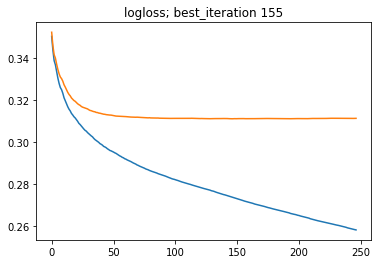

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

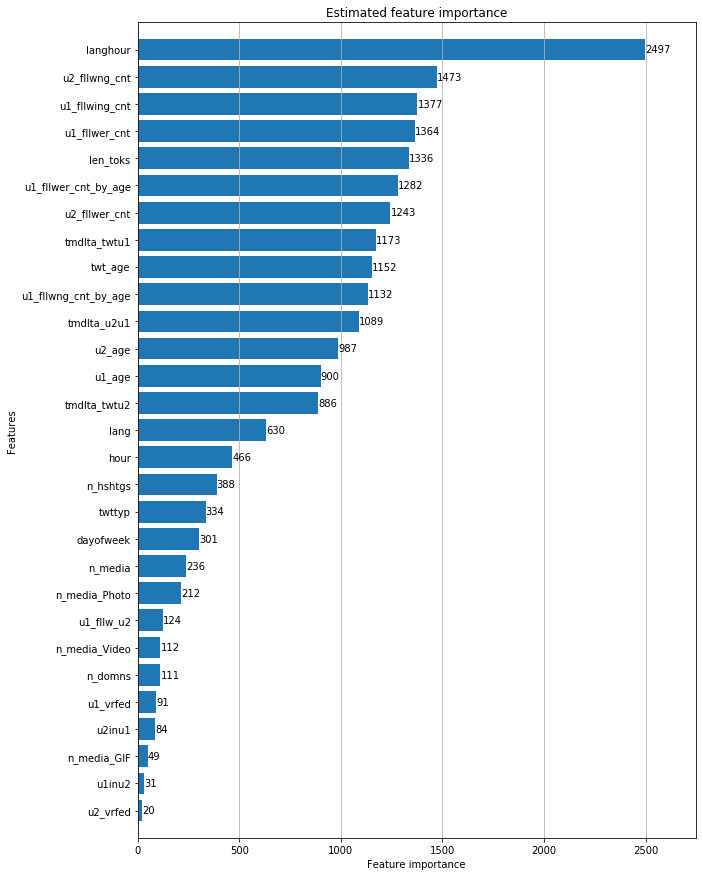

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,2497
6,u2_fllwng_cnt,1473
3,u1_fllwing_cnt,1377
2,u1_fllwer_cnt,1364
11,len_toks,1336
26,u1_fllwer_cnt_by_age,1282
5,u2_fllwer_cnt,1243
21,tmdlta_twtu1,1173
23,twt_age,1152
27,u1_fllwng_cnt_by_age,1132


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 2497),
 ('u2_fllwng_cnt', 1473),
 ('u1_fllwing_cnt', 1377),
 ('u1_fllwer_cnt', 1364),
 ('len_toks', 1336),
 ('u1_fllwer_cnt_by_age', 1282),
 ('u2_fllwer_cnt', 1243),
 ('tmdlta_twtu1', 1173),
 ('twt_age', 1152),
 ('u1_fllwng_cnt_by_age', 1132),
 ('tmdlta_u2u1', 1089),
 ('u2_age', 987),
 ('u1_age', 900),
 ('tmdlta_twtu2', 886),
 ('lang', 630),
 ('hour', 466),
 ('n_hshtgs', 388),
 ('twttyp', 334),
 ('dayofweek', 301),
 ('n_media', 236),
 ('n_media_Photo', 212),
 ('u1_fllw_u2', 124),
 ('n_media_Video', 112),
 ('n_domns', 111),
 ('u1_vrfed', 91),
 ('u2inu1', 84),
 ('n_media_GIF', 49),
 ('u1inu2', 31),
 ('u2_vrfed', 20)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u2_fllwng_cnt',
 'u1_fllwing_cnt',
 'u1_fllwer_cnt',
 'len_toks',
 'u1_fllwer_cnt_by_age',
 'u2_fllwer_cnt',
 'tmdlta_twtu1',
 'twt_age',
 'u1_fllwng_cnt_by_age',
 'tmdlta_u2u1',
 'u2_age',
 'u1_age',
 'tmdlta_twtu2',
 'lang',
 'hour',
 'n_hshtgs',
 'twttyp',
 'dayofweek',
 'n_media',
 'n_media_Photo',
 'u1_fllw_u2',
 'n_media_Video',
 'n_domns',
 'u1_vrfed',
 'u2inu1',
 'n_media_GIF',
 'u1inu2',
 'u2_vrfed']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 51.6 s, sys: 2.45 s, total: 54.1 s
Wall time: 10.1 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 5.91 s, sys: 209 ms, total: 6.12 s
Wall time: 5.95 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4908
auc_vl:  0.3239
auc_val: 0.3098

rce_tr:  23.4173
rce_vl:  12.6544
rce_val: 11.7162


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.3098-11.7162


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 9.7 ms, sys: 0 ns, total: 9.7 ms
Wall time: 18.6 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 21:18:50 start
2020-04-11 21:18:50 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 21:18:50 freq of tags
2020-04-11 21:18:50 done
CPU times: user 208 ms, sys: 6.31 ms, total: 214 ms
Wall time: 242 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 58.3 ms, sys: 207 ms, total: 266 ms
Wall time: 61.6 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)